In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.io as sio
from time import time
import pickle as pkl
import multiprocessing
import sys
sys.path.append(r'/home/datamake8/Function')
from Function_copy import *
from datetime import datetime,timedelta

class params:
    min_data_path = r'/home/datamake8/basic_data/tonglian_data2/min_data'
    score_dict = {
        '1d_min':{'30m':r'/home/datamake8/datamake94/second_score/min_score_period1d_allstock_adj_transformer_final_select3_doublenorm_period30',
                  'ts':r'/home/datamake8/datamake94/second_score/min_score_t0_qtable10_DCNBERT2',   
        },
        'min':"/home/datamake8/data0/min_score_period1d_allstock_adj_transformer_final_select3_doublenorm_period30",
        'second':{'300s':r'/home/datamake8/datamake94/second_score/dcn_bert_multiperiod_5m_final_0529_factor1057_wccc_all_sota2_final',
                    '15s':r'/home/datamake8/datamake94/second_score/dcn_bert_multiperiod_15s_final_0529_factor1057_wccc_all_sota2_final',
                    '60s':r'/home/datamake8/datamake94/second_score/dcn_bert_multiperiod_1m_final_0529_factor1057_wccc_all_sota2_final',
                    '900s':r'/home/datamake8/datamake94/second_score/dcn_bert_multiperiod_15m_final_0323_wccc_all_yy'},
        'second_old':{
            '300s':r'/home/datamake8/datamake94/second_score/dcn_bert_multiperiod_5m_final_0323_wccc_all',
            '60s':r'/home/datamake8/datamake94/second_score/dcn_bert_multiperiod_1m_final_0323_wccc_all',
        }
    }
    index_path = r'/home/datamake8/basic_data/tonglian_data2/support_data'
    support_path = r'/home/datamake8/data0/trade_support'
    ohlc_path = r'/home/datamake8/basic_data/tonglian_data2/ohlc_fea'
    test_result_path = r'/home/datamake8/data0/t0_backtest'

    positions_path=r'/home/datamake8/database_00/LZ底仓_valid3'
    black_path=r'/home/datamake8/data0/black_list'
    sec_lobdata_path = r'/home/datamake8/hft_database/nas3'
    sec_table_path=r'/home/datamake8/hft_database/nas3/sec_fea_table'

    # 场外信息
    os.chdir(ohlc_path)
    high_limit = pd.read_pickle('LIMIT_UP_PRICE.pkl').replace(0,np.nan).ffill()
    low_limit = pd.read_pickle('LIMIT_DOWN_PRICE.pkl').replace(0,np.nan).ffill()
    pre_close = pd.read_pickle('PRE_CLOSE_PRICE.pkl').replace(0,np.nan).ffill()
    close = pd.read_pickle('CLOSE_PRICE.pkl').replace(0,np.nan).ffill()
    open_price = pd.read_pickle('OPEN_PRICE.pkl').replace(0,np.nan).ffill()

    close_price_2 = pd.read_pickle('CLOSE_PRICE_2.pkl').replace(0,np.nan).ffill()
    close_price_2.index = pd.to_datetime(close_price_2.index).strftime('%Y%m%d')
    close_price_2.columns = close_price_2.columns.astype(int)
    
    close_price = pd.read_pickle('CLOSE_PRICE.pkl').replace(0,np.nan).ffill()
    close_price.index = pd.to_datetime(close_price.index).strftime('%Y%m%d')
    close_price.columns = close_price.columns.astype(int)

    next_open = pd.read_pickle('OPEN_PRICE.pkl').replace(0,np.nan).ffill().shift(-1)
    pre_amt = pd.read_pickle('TURNOVER_VALUE.pkl').shift(1).fillna(0)
    adj_factor = pd.read_pickle('ACCUM_ADJ_FACTOR_2.pkl').replace(0,np.nan).ffill()

    upper_price = high_limit
    lower_price = low_limit
    upper_price_warning = pre_close + 0.95 * (high_limit - pre_close) # 个股达到涨停价的90%就不再买入
    lower_price_warning = pre_close + 0.95 * (low_limit - pre_close) # 个股达到跌停价的90%就不再卖出
    adj = adj_factor / adj_factor.shift(1)

    sec_list_all=calc_time_series()
    sec_list_all=[x for x in sec_list_all if x<=145459]
    sec_list=sec_list_all[::5]  #5s一个因子

    # #读取成分股数据
    # idx_stock_dict = {}
    # for idx in ['沪深300','中证500','中证1000']:
    #     df = pd.read_feather(r'/home/datamake8/data0/support_data/%s成份_tl.fea'%idx)
    #     df['code'] = df['code'].apply(lambda x:int(x[2:]))
    #     df['date'] = df['date'].astype(str)
    #     idx_stock_dict[idx] = df

In [29]:
class stk:
    def __init__(self, code, up_price, low_price, up_price_warning, low_price_warning, pre_close, trade_fee=0.0015):
        '''
        对于每只股票，创建一个对象，用于管理个股信息以及执行个股交易
        '''
        #个股静态信息
        self.code = code
        self.up_price = up_price  # 涨停价，涨停不买，跌停不卖
        self.low_price = low_price  # 跌停价
        self.up_price_warning = up_price_warning  # 涨停预警价，不买入
        self.low_price_warning = low_price_warning
        self.lastday_vol = 0  # 昨日持仓量，初始为0
        self.rq_vol = 0  # 已融券量
        self.max_buy = 0  # 当日最大可买量，初始为0，持有一日之后，最大可买量为前一日持有量
        self.max_sell = 0  # 当日最大可卖量，初始为0，持有一日之后，最大可卖量为前一日持有量
        self.trade_fee = trade_fee  # 交易费用与冲击成本，卖出时考虑
        self.minimum_vol = 200 if ('%06d'%int(code))[:2]=='68' else 100 # 68开头的沪市科创板股票最少交易200股
        self.rq_deadline = 0  # 融券到期日

        #个股动态信息
        self.pre_close = pre_close  # 个股前一日收盘价
        self.price = None  # 个股价格
        self.b1_price = None  # 个股买一价
        self.s1_price = None  # 个股卖一价
        self.b1_vol = None  # 个股买一量
        self.s1_vol = None  # 个股卖一量
        self.minute_amt_b = 0 # 个股当前时点可买入的最大金额
        self.minute_amt_s = 0 # 个股当前时点可卖出的最大金额
        self.volume = 0  #  持仓量
        self.amt = 0  # 持仓市值
        self.debt_vol = 0  # 融券卖出后剩余量
        self.debt_amt = 0  # 融券卖出后剩余量市值
        self.balance_vol = 0  # 当日目标持仓量
        self.balance_vol_rq = 0  # 当日目标融券持仓量
    
    def update_info(self, up_price, low_price, up_price_warning, low_price_warning, pre_close, trade_fee=0.0015): # 每日开盘刷新个股行业、市值分组、涨跌停价等
        self.up_price = up_price  # 涨停价
        self.low_price = low_price  # 跌停价
        self.up_price_warning = up_price_warning
        self.low_price_warning = low_price_warning
        self.trade_fee = trade_fee
        self.pre_close = pre_close
        return
        
    def update_price(self, price, b1_price, s1_price, b1_vol, s1_vol):  # 更新个股的价格以及持仓市值
        self.price = price
        self.b1_price = min(b1_price,s1_price-0.01)
        self.s1_price = max(s1_price,b1_price+0.01)
        self.b1_vol = b1_vol
        self.s1_vol = s1_vol
        self.amt = self.volume * price
        self.debt_amt = self.debt_vol * price
        return

    def buy(self, volume, inst=True):  # 买入个股，记录成交信息，刷新持仓市值，返回成交金额；
        if not inst:
            target_price = self.price # 当前买入金额
        elif inst:
            target_price = self.s1_price # 当前买入金额，即刻成交抢对手价
        amt = volume * target_price
        self.volume += volume  # 更新个股累计持仓量
        self.minute_amt_b -= amt
        self.max_buy -= volume  # 更新个股当日可买量
        self.amt = self.volume * self.price  #更新个股累计持仓市值
        return (target_price, amt, self.volume, self.amt)  # 返回买入金额，配置新增额，持仓量、持仓市值
        
    def sell(self, volume, inst=True):  # 卖出个股，记录成交信息，刷新持仓市值，返回成交金额；
        if not inst:
            target_price = self.price # 当前卖出金额
        elif inst:
            target_price = self.b1_price # 当前卖出金额，即刻成交抢对手价
        amt = volume * target_price * (1-self.trade_fee)
        self.volume -= volume # 更新个股持仓量
        self.minute_amt_s -= amt
        self.lastday_vol -= volume
        if self.lastday_vol < 0:
            raise ValueError('卖出超过昨日持仓量')
        self.max_sell -= volume # 更新个股当日可卖量
        self.amt = self.volume * self.price # 更新个股持仓市值
        return (target_price, amt, self.volume, self.amt)  # 返回卖出金额，配置减少额，持仓量、持仓市值

    def stock_rq(self, rq_volume):  # 个股进行融券
        self.rq_vol += rq_volume
        self.debt_vol += rq_volume
        self.debt_amt = self.debt_vol * self.price

        #设置个股的融券到期日，设一个5-10的随机数
        self.rq_deadline = np.random.randint(5,10)
        return

    def stock_hq(self, hq_volume):  # 个股进行还券
        self.rq_vol -= hq_volume
        self.debt_vol -= hq_volume
        self.debt_amt = self.debt_vol * self.price
        # if self.rq_vol != 0: print(f'未正常还券：{self.code}')
        return

    def rq_buy(self, volume, inst=True):  # 融券买回个股
        if not inst:
            target_price = self.price # 当前买入金额
        elif inst:
            target_price = self.s1_price # 当前买入金额，即刻成交抢对手价
        amt = volume * target_price
        self.debt_vol += volume
        self.minute_amt_b -= amt
        self.max_buy -= volume  # 更新个股当日可买量
        self.debt_amt = self.debt_vol * self.price  # 更新个股融券持仓市值
        return (target_price, amt, self.debt_vol, self.debt_amt)

    def rq_sell(self, volume, inst=True, need_fee=True, use_target_price=None):  # 融券卖出个股
        if use_target_price is not None:
            target_price = use_target_price
        else:
            if not inst:
                target_price = self.price # 当前买入金额
            elif inst:
                target_price = self.b1_price # 当前买入金额，即刻成交抢对手价
        if need_fee:
            amt = volume * target_price * (1-self.trade_fee)
        else:
            amt = volume * target_price
        self.debt_vol -= volume
        self.minute_amt_s -= amt
        self.max_sell -= volume  # 更新个股当日可卖量
        self.debt_amt = self.debt_vol * self.price  # 更新个股融券持仓市值
        return (target_price, amt, self.debt_vol, self.debt_amt)
    
class account:
    '''
    创建一个账户类，用于刷新账户信息，管理股票信息，规划交易任务以及执行
    update20240515: 携带融资功能
    '''
    def __init__(self,money):
        # 现金账户
        self.code_list = []         # 可考虑的股票列表
        self.tot_account = money    # 账户总资产
        self.stk_amt = 0            # 股票总资产
        self.cash = money           # 现金
        self.initial_money = money  # 初始资产

        #保证金账户
        self.rq_amt = 0               # 融券总量
        self.valid_insurance = money  # 可用保证金
        self.used_insurance = 0       # 已用保证金
        self.lock_cash = 0            # 锁定资金
        self.rq_fee = (1 + 0.08) ** (1./255) - 1  #融券费率

        #其他信息
        self.stk_dict = {}  # 全市场股票信息
        self.trade_dict = {}  # 个股交易记录，分股票
        self.decision_list = []  # 记录决策列表
        self.time = ' '  # 当前时间戳
        self.shishi_rq_list = []  # 当日可实时融券股票列表
        
    def cal_tot(self): # 刷新持仓信息，统计账户总市值
        #统计现金账户和保证金账户的资产
        #1.现金账户
        account1_asset = 0
        for code in self.stk_dict.keys():
            if self.stk_dict[code].price is not None and not np.isnan(self.stk_dict[code].price):
                self.stk_dict[code].amt = self.stk_dict[code].price * self.stk_dict[code].volume
                account1_asset += self.stk_dict[code].amt
        self.stk_amt = account1_asset
        account1_asset += self.cash

        #2.保证金账户
        self.used_insurance = 0  # 清零重新计算保证金
        self.rq_amt = 0          # 清零重新计算融券总量
        account2_asset = 0
        account2_debt = 0
        for code in self.stk_dict.keys():
            if self.stk_dict[code].price is not None and not np.isnan(self.stk_dict[code].price):
                self.stk_dict[code].debt_amt = self.stk_dict[code].price * self.stk_dict[code].debt_vol
                account2_asset += self.stk_dict[code].debt_amt
                self.used_insurance += (self.stk_dict[code].rq_vol - self.stk_dict[code].debt_vol) * self.stk_dict[code].price
                self.rq_amt += self.stk_dict[code].rq_vol * self.stk_dict[code].price
                account2_debt += self.stk_dict[code].price * self.stk_dict[code].rq_vol
        account2_asset += self.lock_cash
        self.tot_account = account1_asset + account2_asset - account2_debt
        self.valid_insurance = self.cash * 1 + self.stk_amt * 0.6 - self.used_insurance
        return self.tot_account

    def log_hold(self): # 统计当前时间持仓情况和现金
        hold_vol, hold_amt, debt_vol, debt_amt, rq_vol, rq_amt = {}, {}, {}, {}, {}, {}
        for code in self.stk_dict.keys():
            if self.stk_dict[code].price is not None and not np.isnan(self.stk_dict[code].price):
                hold_vol[code] = self.stk_dict[code].volume
                hold_amt[code] = self.stk_dict[code].amt
                debt_vol[code] = self.stk_dict[code].debt_vol
                debt_amt[code] = self.stk_dict[code].debt_amt
                rq_vol[code] = self.stk_dict[code].rq_vol
                rq_amt[code] = self.stk_dict[code].rq_vol * self.stk_dict[code].price
        hold_df = pd.DataFrame([hold_vol, hold_amt, debt_vol, debt_amt, rq_vol, rq_amt], index=['hold_vol','hold_amt','debt_vol','debt_amt','rq_vol','rq_amt']).T
        hold_df['cash'] = self.cash
        hold_df['lock_cash'] = self.lock_cash
        return hold_df      
    
    def refresh_open(self, code_list,daily_position,td_upper,td_lower,td_upper_warning,td_lower_warning,pre_close,b1_price,s1_price,b1_vol,s1_vol,mean_price,date_str):  # 每天开盘刷新策略持仓相关信息
        '''
        code_list 为当日可考虑的股票池
        td_citic 全市场个股行业信息
        td_cmvg 全市场市值分组信息
        td_upper 全市场个股当日涨停价
        td_lower 全市场个股当日跌停价
        stk_perm 当前账户各股票可允许的最大持仓市值，会在指数的个股持仓基础上调整
        '''
        
        if date_str < '20230828': trade_fee =0.0013
        else: trade_fee = 0.0008
        for code in code_list: # 开盘刷新所有个股信息，可能有新上市的，可能有市值分组变动的，涨跌停价格也会发生变化
            if code not in self.stk_dict.keys():  # 新上市股票信息新增
                self.stk_dict[code] = stk(code,td_upper[code], td_lower[code],td_upper_warning[code],td_lower_warning[code],pre_close[code],trade_fee=trade_fee)
            else:   # 已上市股票信息刷新
                self.stk_dict[code].update_info(td_upper[code], td_lower[code],td_upper_warning[code],td_lower_warning[code],pre_close[code],trade_fee=trade_fee) # 更新个股行业、市值、涨跌停价等

        #更新当日可卖量信息
        for code in self.stk_dict.keys():
            self.stk_dict[code].lastday_vol = self.stk_dict[code].volume
            self.stk_dict[code].max_buy = self.stk_dict[code].lastday_vol + self.stk_dict[code].debt_vol
            self.stk_dict[code].max_sell = self.stk_dict[code].lastday_vol + self.stk_dict[code].debt_vol

        self.upper_price = td_upper.reindex(code_list)
        self.lower_price = td_lower.reindex(code_list)
        self.upper_price_warning = td_upper_warning.reindex(code_list)
        self.lower_price_warning = td_lower_warning.reindex(code_list)
        # self.fresh_second(mean_price,b1_price,s1_price,b1_vol,s1_vol) # 刷新个股的分钟可参与金额和成交价
        self.fresh_second(pre_close, pre_close, pre_close, b1_vol, s1_vol)  # 先用昨收刷新成交价

        #1.根据前一日持仓，分配仓位
        self.cal_tot()
        pre_amt = daily_position['pre_amt']
        for code in pre_amt.keys():
            stk_now = self.stk_dict[code]
            unit_vol = stk_now.minimum_vol
            target_amt = self.tot_account * 0.67 * pre_amt[code]
            if target_amt > 0:
                target_vol = round((target_amt / stk_now.pre_close) / unit_vol, 0) * unit_vol
                target_amt = target_vol * stk_now.pre_close
                self.stk_dict[code].volume = target_vol
                self.stk_dict[code].lastday_vol = target_vol
                self.stk_dict[code].amt = target_amt
                self.cash -= target_amt
            elif target_amt < 0:
                target_vol = round((-target_amt / stk_now.pre_close) / unit_vol, 0) * unit_vol
                target_amt = target_vol * stk_now.pre_close
                self.stk_dict[code].stock_rq(target_vol)
                self.rq_sell_stk(code,target_vol,need_fee=False,log_trade=False,use_target_price=stk_now.pre_close)

        self.cal_tot()
        self.open_hold_df = self.log_hold()
        self.fresh_second(mean_price,b1_price,s1_price,b1_vol,s1_vol) # 刷新个股的分钟可参与金额和成交价
        self.cal_tot()
        now_amt = daily_position['now_amt']
        pre_amt = daily_position['pre_amt']
        for code in code_list:
            if code not in now_amt.keys(): continue  #既不在昨仓也不在今仓
            #2.挑选昨仓为空的股票，看今日的平衡持仓和所需操作
            if pre_amt[code] < 0:  # 昨日融券
                stk_now = self.stk_dict[code]
                unit_vol = stk_now.minimum_vol
                target_amt = self.tot_account * 0.67 * now_amt[code]
                pre_rq_vol = stk_now.rq_vol
                if target_amt <= 0: # 继续做空头，或者平仓
                    target_vol = round((-target_amt / stk_now.pre_close) / unit_vol, 0) * unit_vol
                    if target_vol > pre_rq_vol: # 今日目标空头大于昨日空头，需要新融券
                        self.stk_dict[code].stock_rq(target_vol - pre_rq_vol)
                        self.stk_dict[code].balance_vol_rq = 0
                        self.stk_dict[code].rq_direction = 'S'
                        self.stk_dict[code].max_buy, self.stk_dict[code].max_sell = 0, target_vol - pre_rq_vol
                    elif target_vol < pre_rq_vol: # 今日目标空头小于昨日空头
                        self.stk_dict[code].balance_vol_rq = self.stk_dict[code].debt_vol + pre_rq_vol - target_vol
                        self.stk_dict[code].rq_direction = 'B'
                        self.stk_dict[code].max_buy, self.stk_dict[code].max_sell = pre_rq_vol - target_vol, 0
                    else:
                        self.stk_dict[code].rq_direction = 'N'
                        self.stk_dict[code].max_buy, self.stk_dict[code].max_sell = 0,0
                elif target_amt > 0:  # 改做多头，balance_vol和balance_vol_rq都要改
                    target_vol = round((target_amt / stk_now.pre_close) / unit_vol, 0) * unit_vol
                    self.stk_dict[code].balance_vol_rq = pre_rq_vol
                    self.stk_dict[code].balance_vol = target_vol
                    self.stk_dict[code].rq_direction = 'B'
                    self.stk_dict[code].max_buy, self.stk_dict[code].max_sell = target_vol + pre_rq_vol, 0
            
            #3.挑选昨仓为多的股票，看今日的平衡持仓和所需操作
            elif pre_amt[code] > 0:  # 昨日做多
                stk_now = self.stk_dict[code]
                unit_vol = stk_now.minimum_vol
                target_amt = self.tot_account * 0.67 * now_amt[code]
                pre_vol = stk_now.volume
                lastday_vol = self.stk_dict[code].lastday_vol
                if target_amt >= 0:  # 继续做多头，或者平仓
                    target_vol = round((target_amt / stk_now.pre_close) / unit_vol, 0) * unit_vol
                    self.stk_dict[code].balance_vol = target_vol
                    self.stk_dict[code].max_buy, self.stk_dict[code].max_sell = lastday_vol + target_vol - pre_vol, lastday_vol
                elif target_amt < 0:  # 需要融券做空
                    target_vol = round((-target_amt / stk_now.pre_close) / unit_vol, 0) * unit_vol
                    self.stk_dict[code].stock_rq(target_vol)
                    self.stk_dict[code].balance_vol_rq = 0
                    self.stk_dict[code].balance_vol = 0
                    self.stk_dict[code].rq_direction = 'S'
                    self.stk_dict[code].max_buy, self.stk_dict[code].max_sell = 0, target_vol + lastday_vol

            #4.昨日空仓的股票，需要今日开仓
            elif pre_amt[code] == 0:
                stk_now = self.stk_dict[code]
                unit_vol = stk_now.minimum_vol
                target_amt = self.tot_account * 0.67 * now_amt[code]
                if target_amt == 0: continue
                elif target_amt > 0:  # 需要做多
                    target_vol = round((target_amt / stk_now.pre_close) / unit_vol, 0) * unit_vol
                    self.stk_dict[code].balance_vol = target_vol
                    self.stk_dict[code].max_buy, self.stk_dict[code].max_sell = target_vol, 0
                elif target_amt < 0:  # 需要做空：
                    target_vol = round((-target_amt / stk_now.pre_close) / unit_vol, 0) * unit_vol
                    self.stk_dict[code].stock_rq(target_vol)
                    self.stk_dict[code].balance_vol_rq = 0
                    self.stk_dict[code].rq_direction = 'S'
                    self.stk_dict[code].max_buy, self.stk_dict[code].max_sell = 0, target_vol
        
        return self.cal_tot()
    
    def log_trade(self, code, price, bsvolume, rqflag): # 交易记录
        if code not in self.trade_dict.keys():
            self.trade_dict[code] = []
        self.trade_dict[code].append([bsvolume, price, self.time, rqflag])
        return

    def buy_stk(self, code, volume, inst=True, log_trade=True): # 买入股票
        target_price, amt, hold_vol, hold_amt = self.stk_dict[code].buy(volume, inst=inst)
        if log_trade: self.log_trade(code,target_price, volume, 'cash')
        self.cash -= amt
        if self.cash<0:
            raise ValueError(code+':'+str(volume)+'现金不足买入')
        return amt
    
    def sell_stk(self, code, volume, inst=True, log_trade=True): # 卖出股票
        target_price, amt, hold_vol, hold_amt = self.stk_dict[code].sell(volume,inst=inst)
        if log_trade: self.log_trade(code,target_price, -volume, 'cash')
        self.cash += amt
        return amt

    def rq_buy_stk(self, code, volume, inst=True, log_trade=True):  # 融券买回股票
        target_price, amt, hold_vol, hold_amt = self.stk_dict[code].rq_buy(volume, inst=inst)
        if log_trade: self.log_trade(code,target_price, volume, 'rq')
        self.lock_cash -= amt  # 冻结资金允许为负，负的冻结资金实盘会用现金补充
        if self.lock_cash < 0:
            self.cash += self.lock_cash
            self.lock_cash = 0
        self.used_insurance -= amt
        self.valid_insurance += amt
        return amt

    def rq_sell_stk(self, code, volume, inst=True, need_fee=True, log_trade=True, use_target_price=None):  # 融券卖出股票
        # #设置随机成交，有50%概率volume为0
        # if need_fee and self.stk_dict[code].price > self.stk_dict[code].b1_price:
        #     volume = 0
        target_price, amt, hold_vol, hold_amt = self.stk_dict[code].rq_sell(volume, inst=inst, need_fee=need_fee, use_target_price=use_target_price)
        if log_trade: self.log_trade(code,target_price, -volume, 'rq')
        self.lock_cash += amt
        self.used_insurance += amt
        self.valid_insurance -= amt
        return amt

    def fresh_second(self, price_s, b1_s, s1_s, b1_vol, s1_vol): # 每秒刷新个股的分钟可参与金额和成交价
        for code in price_s.keys():
            self.stk_dict[code].update_price(price_s[code], b1_s[code], s1_s[code], b1_vol[code], s1_vol[code])  # 刷新个股价格
        return

    def fresh_second_total(self, price_s, b1_s, s1_s, b1_vol, s1_vol): # 每秒刷新个股的分钟可参与金额和成交价，总体刷新以加快运算速度
        self.price_s = price_s
        self.b1_s = b1_s
        self.s1_s = s1_s
        self.b1_vol = b1_vol
        self.s1_vol = s1_vol
        return
    
    def fresh_amt(self, minute_amt):
        for code in minute_amt.keys():
            self.stk_dict[code].minute_amt_b = minute_amt[code]
            self.stk_dict[code].minute_amt_s = minute_amt[code]
        return

    def decide_clean(self, buy_codes, sell_codes, buy_codes_back, sell_codes_back, inst=True, vol_limit_ratio=0.5):
        '''
        每分钟根据最新的打分排序，以及可以买卖的金额，做出任务计划
        max_buy 当前分钟可买入金额
        max_sell 当前分钟可卖出金额
        buy_codes 考虑买入的股票池，根据打分从大到小排序
        sell_codes 考虑卖出的股票池，根据打分从小到大排序
        '''
        # 重置买入和卖出金额
        self.tot_buy_amt_cash = 0
        self.tot_sell_amt_cash = 0
        self.tot_buy_amt_rq = 0
        self.tot_sell_amt_rq = 0
        # 由于分为现金账户和保证金账户交易，两个账户的最大可买可卖量不同
        self.max_buy_cash = max(min(self.cash, 0.7 * self.tot_account - self.stk_amt, 0.05 * self.tot_account - (self.stk_amt - self.used_insurance)), 0)
        self.max_sell_cash = max(0.05 * self.tot_account - (self.used_insurance - self.stk_amt), 0)
        self.max_buy_rq = max(self.lock_cash, 0)
        self.max_sell_rq = max(min(self.valid_insurance, 0.7 * self.tot_account - self.used_insurance), 0)
        self.ans_str = self.time
        upper_warning_code = self.price_s[self.price_s > self.upper_price_warning].index.tolist()
        lower_warning_code = self.price_s[self.price_s < self.lower_price_warning].index.tolist()

        if self.max_buy_cash > 0 or self.max_buy_rq > 0:
            for buy_code in upper_warning_code:
                if self.tot_buy_amt_cash <= self.max_buy_cash - 1000 or self.tot_buy_amt_rq <= self.max_buy_rq - 1000:  # 直至无法添加
                    self.stk_dict[buy_code].update_price(self.price_s[buy_code], self.b1_s[buy_code], self.s1_s[buy_code], self.b1_vol[buy_code], self.s1_vol[buy_code])
                    self.decide_buy(buy_code, inst=inst, vol_limit_ratio=vol_limit_ratio, balance=True)
                else:
                    break
            
            for buy_code in buy_codes:  # 从可买列表往后找，可买则买
                if self.tot_buy_amt_cash <= self.max_buy_cash - 1000 or self.tot_buy_amt_rq <= self.max_buy_rq - 1000:  # 直至无法添加
                    self.stk_dict[buy_code].update_price(self.price_s[buy_code], self.b1_s[buy_code], self.s1_s[buy_code], self.b1_vol[buy_code], self.s1_vol[buy_code])
                    self.decide_buy(buy_code, inst=inst, vol_limit_ratio=vol_limit_ratio, balance=False)
                else:
                    break

            for buy_code in buy_codes_back:
                if self.tot_buy_amt_cash <= self.max_buy_cash - 1000 or self.tot_buy_amt_rq <= self.max_buy_rq - 1000:  # 直至无法添加
                    self.stk_dict[buy_code].update_price(self.price_s[buy_code], self.b1_s[buy_code], self.s1_s[buy_code], self.b1_vol[buy_code], self.s1_vol[buy_code])
                    self.decide_buy(buy_code, inst=inst, vol_limit_ratio=vol_limit_ratio, balance=True)
                else:
                    break

        if self.max_sell_cash + self.tot_buy_amt_cash > 0 or self.max_sell_rq + self.tot_buy_amt_rq > 0:
            for sell_code in lower_warning_code:
                if self.tot_sell_amt_cash <= self.max_sell_cash + self.tot_buy_amt_cash or self.tot_sell_amt_rq <= self.max_sell_rq + self.tot_buy_amt_rq:  # 直至无法添加
                    self.stk_dict[sell_code].update_price(self.price_s[sell_code], self.b1_s[sell_code], self.s1_s[sell_code], self.b1_vol[sell_code], self.s1_vol[sell_code])
                    self.decide_sell(sell_code, inst=inst, vol_limit_ratio=vol_limit_ratio, balance=True)
                else:
                    break

            for sell_code in sell_codes:  # 从可卖列表从前往后找，可卖则卖
                if self.tot_sell_amt_cash <= self.max_sell_cash + self.tot_buy_amt_cash or self.tot_sell_amt_rq <= self.max_sell_rq + self.tot_buy_amt_rq:  # 直至无法添加
                    self.stk_dict[sell_code].update_price(self.price_s[sell_code], self.b1_s[sell_code], self.s1_s[sell_code], self.b1_vol[sell_code], self.s1_vol[sell_code])
                    self.decide_sell(sell_code, inst=inst, vol_limit_ratio=vol_limit_ratio, balance=False)
                else:
                    break

            for sell_code in sell_codes_back:
                if self.tot_sell_amt_cash <= self.max_sell_cash + self.tot_buy_amt_cash or self.tot_sell_amt_rq <= self.max_sell_rq + self.tot_buy_amt_rq:  # 直至无法添加
                    self.stk_dict[sell_code].update_price(self.price_s[sell_code], self.b1_s[sell_code], self.s1_s[sell_code], self.b1_vol[sell_code], self.s1_vol[sell_code])
                    self.decide_sell(sell_code, inst=inst, vol_limit_ratio=vol_limit_ratio, balance=True)
                else:
                    break

        tot_buy_amt = self.tot_buy_amt_cash + self.tot_buy_amt_rq
        tot_sell_amt = self.tot_sell_amt_cash + self.tot_sell_amt_rq
        self.ans_str += ' BM:' + str(round(tot_buy_amt, 2)) + ' SM:' + str(round(tot_sell_amt, 2))
        self.decision_list.append(self.ans_str)
        return tot_buy_amt, tot_sell_amt

    def decide_buy(self, buy_code, inst=True, vol_limit_ratio=0.5, balance=False):
        stk_now = self.stk_dict[buy_code]
        if stk_now.rq_vol > 0 and (balance is False | (balance is True and stk_now.balance_vol_rq > stk_now.debt_vol)):  # 保证金账户可交易，优先保证金账户买入
            price = stk_now.price if not inst else stk_now.s1_price
            if stk_now.rq_direction == 'S' or stk_now.rq_direction == 'N':
                return 0  # 当日该股融券买卖方向为卖，不再买入
            # if balance is True and stk_now.balance_vol_rq <= stk_now.debt_vol:
            #     return 0
            if np.isnan(price) or price == 0:
                return 0
            unit_vol = stk_now.minimum_vol
            vol_limit = min(max(unit_vol, int(vol_limit_ratio * stk_now.s1_vol // unit_vol) * unit_vol), stk_now.s1_vol // unit_vol * unit_vol) if inst else 99999999999
            minute_amt_limit = max(int(stk_now.minute_amt_b / (unit_vol * price)) * unit_vol, unit_vol) if stk_now.minute_amt_b > 0 else 0
            if price < stk_now.up_price:  # 可以进行交易，进行下一步考虑
                if balance:
                    lack_vol = max(stk_now.balance_vol_rq - stk_now.debt_vol, 0)
                    buyable_vol = min(int((self.max_buy_rq - self.tot_buy_amt_rq) / (unit_vol * price)) * unit_vol, lack_vol, stk_now.max_buy, minute_amt_limit, vol_limit)
                else:
                    if price < stk_now.low_price_warning:
                        return 0
                    buyable_vol = min(int((self.max_buy_rq - self.tot_buy_amt_rq) / (unit_vol * price)) * unit_vol, stk_now.max_buy - stk_now.balance_vol, minute_amt_limit, vol_limit)
                if buyable_vol >= unit_vol:
                    self.tot_buy_amt_rq += self.rq_buy_stk(buy_code, buyable_vol, inst=inst)
                    self.ans_str += ' B:' + buy_code + ':' + str(buyable_vol)
                    return 0  # 若有交易，提前退出决策

        if stk_now.lastday_vol > 0 or stk_now.balance_vol > 0:  # 现金账户可交易
            price = stk_now.price if not inst else stk_now.s1_price
            if balance is True and stk_now.balance_vol <= stk_now.volume:
                return 0
            if np.isnan(price) or price == 0:
                return 0
            unit_vol = stk_now.minimum_vol
            vol_limit = min(max(unit_vol, int(vol_limit_ratio * stk_now.s1_vol // unit_vol) * unit_vol), stk_now.s1_vol // unit_vol * unit_vol) if inst else 99999999999
            minute_amt_limit = max(int(stk_now.minute_amt_b / (unit_vol * price)) * unit_vol, unit_vol) if stk_now.minute_amt_b > 0 else 0
            if price < stk_now.up_price:  # 可以进行交易，进行下一步考虑
                if balance:
                    lack_vol = max(stk_now.balance_vol - stk_now.volume, 0)
                    buyable_vol = min(int((self.max_buy_cash - self.tot_buy_amt_cash) / (unit_vol * price)) * unit_vol, lack_vol, stk_now.max_buy, minute_amt_limit, vol_limit)
                else:
                    if price < stk_now.low_price_warning:
                        return 0
                    buyable_vol = min(int((self.max_buy_cash - self.tot_buy_amt_cash) / (unit_vol * price)) * unit_vol, stk_now.max_buy - (stk_now.rq_vol - stk_now.debt_vol), minute_amt_limit, vol_limit)
                if buyable_vol >= unit_vol:
                    self.tot_buy_amt_cash += self.buy_stk(buy_code, buyable_vol, inst=inst)
                    self.ans_str += ' B:' + buy_code + ':' + str(buyable_vol)
                    return 0  # 若有交易，提前退出决策
        return 0

    def decide_sell(self, sell_code, inst=True, vol_limit_ratio=0.5, balance=False):
        stk_now = self.stk_dict[sell_code]
        if stk_now.lastday_vol > 0 and (balance is False | (balance is True and stk_now.balance_vol < stk_now.volume)):  # 现金账户可交易，优先现金账户卖出
            price = stk_now.price if not inst else stk_now.b1_price
            # if balance is True and stk_now.balance_vol >= stk_now.volume:
            #     return 0
            if np.isnan(price) or price == 0:
                return 0
            unit_vol = stk_now.minimum_vol
            vol_limit = min(max(unit_vol, int(vol_limit_ratio * stk_now.b1_vol // unit_vol) * unit_vol), stk_now.b1_vol // unit_vol * unit_vol) if inst else 99999999999
            minute_amt_limit = max(int(stk_now.minute_amt_s / (unit_vol * price)) * unit_vol, unit_vol) if stk_now.minute_amt_s > 0 else 0
            if price > stk_now.low_price:  # 可以进行交易，进行下一步考虑
                if balance:
                    lack_vol = max(stk_now.volume - stk_now.balance_vol, 0)
                    sellable_vol = min(int((self.max_sell_cash + self.tot_buy_amt_cash - self.tot_sell_amt_cash) / (unit_vol * price)) * unit_vol, lack_vol, \
                        stk_now.max_sell, stk_now.lastday_vol, minute_amt_limit, vol_limit)
                else:
                    if price > stk_now.up_price_warning:
                        return 0
                    sellable_vol = min(int((self.max_sell_cash + self.tot_buy_amt_cash - self.tot_sell_amt_cash) / (unit_vol * price)) * unit_vol, \
                        stk_now.max_sell - (stk_now.rq_vol - stk_now.balance_vol_rq), stk_now.lastday_vol, minute_amt_limit, vol_limit)
                if sellable_vol >= unit_vol:
                    self.tot_sell_amt_cash += self.sell_stk(sell_code, sellable_vol, inst=inst)
                    self.ans_str += ' S:' + sell_code + ':' + str(sellable_vol)
                    return 0

        if stk_now.rq_vol > 0:  # 保证金账户可交易
            price = stk_now.price if not inst else stk_now.b1_price
            if stk_now.rq_direction == 'B' or stk_now.rq_direction == 'N':
                return 0  # 当日该股融券买卖方向为买，不再卖出
            if balance is True and stk_now.balance_vol_rq >= stk_now.debt_vol:
                return 0
            if np.isnan(price) or price == 0:
                return 0
            unit_vol = stk_now.minimum_vol
            vol_limit = min(max(unit_vol, int(vol_limit_ratio * stk_now.b1_vol // unit_vol) * unit_vol), stk_now.b1_vol // unit_vol * unit_vol) if inst else 99999999999
            minute_amt_limit = max(int(stk_now.minute_amt_s / (unit_vol * price)) * unit_vol, unit_vol) if stk_now.minute_amt_s > 0 else 0
            if price > stk_now.low_price:
                if balance:
                    lack_vol = max(stk_now.debt_vol - stk_now.balance_vol_rq, 0)
                    sellable_vol = min(int((self.max_sell_rq + self.tot_buy_amt_rq - self.tot_sell_amt_rq) / (unit_vol * price)) * unit_vol, lack_vol, \
                        stk_now.max_sell, stk_now.debt_vol, minute_amt_limit, vol_limit)
                else:
                    if price > stk_now.up_price_warning:
                        return 0
                    sellable_vol = min(int((self.max_sell_rq + self.tot_buy_amt_rq - self.tot_sell_amt_rq) / (unit_vol * price)) * unit_vol, \
                        stk_now.max_sell - stk_now.lastday_vol, stk_now.debt_vol, minute_amt_limit, vol_limit)
                if sellable_vol >= unit_vol:
                    self.tot_sell_amt_rq += self.rq_sell_stk(sell_code, sellable_vol, inst=inst)
                    self.ans_str += ' S:' + sell_code + ':' + str(sellable_vol)
                    return 0
        return 0

    def close_today(self): # 每日收盘整理
        hold_dict = {}
        for code in self.stk_dict.keys():
            if self.stk_dict[code].volume > 0:
                hold_dict[code] = [self.stk_dict[code].volume,self.stk_dict[code].lastday_vol, self.stk_dict[code].price, self.stk_dict[code].amt]
        hold_df = pd.DataFrame(hold_dict,index=['vol','lastday_vol','price','amt']).T.sort_index()
        trade_df = pd.concat([pd.DataFrame(self.trade_dict[x]) for x in self.trade_dict.keys()],keys=self.trade_dict.keys()).reset_index() if len(self.trade_dict)>0 else pd.DataFrame(columns=['code','idx','volume','price','time', 'rqflag'])
        trade_df.columns = ['code','idx','volume','price','time', 'rqflag']
        del trade_df['idx']
        trade_df.sort_values(['time'])
        self.trade_dict = {}
        decision_s = pd.Series(self.decision_list,dtype=object)
        self.decision_list = []
        for code in self.stk_dict.keys():
            if self.stk_dict[code].volume == 0:
                self.stk_dict[code].hold_date = 0

        self.close_hold_df = self.log_hold()

        #扣除券息
        self.cal_tot()
        self.cash -= self.rq_amt * self.rq_fee
        assert self.cash >= 0, '现金不足支付融券费用，则报错'

        # #模拟还券
        # for code in self.stk_dict.keys():
        #     if self.stk_dict[code].rq_deadline <= 0:
        #         if self.stk_dict[code].debt_vol > 0:
        #             hq_volume = min(self.stk_dict[code].debt_vol, self.stk_dict[code].rq_vol)
        #             self.stk_dict[code].stock_hq(hq_volume)
        # for code in self.stk_dict.keys():
        #     if self.stk_dict[code].rq_vol == 0:
        #         self.stk_dict[code].rq_deadline = 0

        # #所有股票扣除融券到期日
        # for code in self.stk_dict.keys():
        #     if self.stk_dict[code].rq_vol > 0:
        #         self.stk_dict[code].rq_deadline -= 1

        return hold_df, trade_df, decision_s

In [30]:
start_date = '20230111'
end_date = '20240321'
date_lsit_all_str=get_datelist_all()
date_list_all=get_datelist_all()
date_list_str=[x for x in date_list_all if x>=start_date and x<=end_date][:]
date_list = [datetime.strptime(x[:8],"%Y%m%d").date() for x in date_list_str]
date_list_all = [datetime.strptime(x[:8],"%Y%m%d").date() for x in date_list_all]
idx = 'zz1000'
idx_name = '中证1000'

In [35]:
def get_secdata(date_str, code_list):
    sec_lobdata_path = params.sec_lobdata_path
    sec_bp1 = pd.read_feather(os.path.join(sec_lobdata_path,'sec_bp1_table',date_str+'.fea')).set_index('time')
    sec_bp1.columns = ['%06d'%int(x) for x in sec_bp1.columns]
    sec_bp1 = sec_bp1.reindex(columns=code_list)
    sec_sp1 = pd.read_feather(os.path.join(sec_lobdata_path,'sec_sp1_table',date_str+'.fea')).set_index('time')
    sec_sp1.columns = ['%06d'%int(x) for x in sec_sp1.columns]
    sec_sp1 = sec_sp1.reindex(columns=code_list)
    sec_bv1 = pd.read_feather(os.path.join(sec_lobdata_path,'sec_bv1_table',date_str+'.fea')).set_index('time').fillna(0)
    sec_bv1.columns = ['%06d'%int(x) for x in sec_bv1.columns]
    sec_bv1 = sec_bv1.reindex(columns=code_list)
    sec_sv1 = pd.read_feather(os.path.join(sec_lobdata_path,'sec_sv1_table',date_str+'.fea')).set_index('time').fillna(0)
    sec_sv1.columns = ['%06d'%int(x) for x in sec_sv1.columns]
    sec_sv1 = sec_sv1.reindex(columns=code_list)
    sec_open = pd.read_feather(os.path.join(params.sec_table_path,'sec_open_table',date_str+'.fea')).set_index('second').fillna(method='ffill')
    sec_open.columns = ['%06d'%int(x) for x in sec_open.columns]
    sec_open = sec_open.reindex(columns=code_list)
    return sec_bp1, sec_sp1, sec_bv1, sec_sv1, sec_open

def get_alpha_dict(code_list, date_str, min_ratio=0.3, score_ratio_1m=0.333,score_ratio_15s=0.333, score_ratio_5m=0.333):
    alpha_dict = {}
    # if date_str >= '20240301':
    #     #获取second打分
    #     factor_score_sec = pd.read_feather(params.score_dict['second']['300s'] + '//%s.fea'%date_str).set_index('second')
    #     factor_score_sec.index = factor_score_sec.index.astype(int)
    #     factor_score_sec.columns = ['%06d'%int(x) for x in factor_score_sec.columns]
    #     factor_score_sec = factor_score_sec.reindex(index=params.sec_list_all, columns=code_list).fillna(method='ffill')
    #     factor_score_sec_std = factor_score_sec.std(axis=1)
    #     factor_score_sec = (factor_score_sec).div(factor_score_sec_std,axis=0)
    #     alpha_dict['sec_300s'] = factor_score_sec

    #     factor_score_sec = alpha_dict['sec_300s']
    #     alpha_dict['score'] = factor_score_sec.shift(1)

    if date_str >= '20230701':
        #获取second打分
        factor_score_sec = pd.read_feather(params.score_dict['second']['300s'] + '//%s.fea'%date_str).set_index('second')
        factor_score_sec.index = factor_score_sec.index.astype(int)
        factor_score_sec.columns = ['%06d'%int(x) for x in factor_score_sec.columns]
        factor_score_sec = factor_score_sec.reindex(index=params.sec_list_all, columns=code_list).fillna(method='ffill')
        factor_score_sec_std = factor_score_sec.std(axis=1)
        factor_score_sec = (factor_score_sec).div(factor_score_sec_std,axis=0)
        alpha_dict['sec_300s'] = factor_score_sec
        
        factor_score_sec = pd.read_feather(params.score_dict['second']['60s'] + '//%s.fea'%date_str).set_index('second')
        factor_score_sec.index = factor_score_sec.index.astype(int)
        factor_score_sec.columns = ['%06d'%int(x) for x in factor_score_sec.columns]
        factor_score_sec = factor_score_sec.reindex(index=params.sec_list_all, columns=code_list).fillna(method='ffill')
        factor_score_sec_std = factor_score_sec.std(axis=1)
        factor_score_sec = (factor_score_sec).div(factor_score_sec_std,axis=0)
        alpha_dict['sec_60s'] = factor_score_sec

        factor_score_sec = pd.read_feather(params.score_dict['second']['15s'] + '//%s.fea'%date_str).set_index('second')
        factor_score_sec.index = factor_score_sec.index.astype(int)
        factor_score_sec.columns = ['%06d'%int(x) for x in factor_score_sec.columns]
        factor_score_sec = factor_score_sec.reindex(index=params.sec_list_all, columns=code_list).fillna(method='ffill')
        factor_score_sec_std = factor_score_sec.std(axis=1)
        factor_score_sec = (factor_score_sec).div(factor_score_sec_std,axis=0)
        alpha_dict['sec_15s'] = factor_score_sec
        
        #打分结果融合
        factor_score_sec = score_ratio_5m*alpha_dict['sec_300s'] + score_ratio_1m*alpha_dict['sec_60s'] + score_ratio_15s*alpha_dict['sec_15s']# + (1-score_ratio_5m-score_ratio_1m-score_ratio_15s)*alpha_dict['sec_900s']
        alpha_dict['score'] = factor_score_sec.shift(1)

    else:
        #获取second打分
        factor_score_sec = pd.read_feather(params.score_dict['second_old']['300s'] + '//%s.fea'%date_str).set_index('second')
        factor_score_sec.index = factor_score_sec.index.astype(int)
        factor_score_sec.columns = ['%06d'%int(x) for x in factor_score_sec.columns]
        factor_score_sec = factor_score_sec.reindex(index=params.sec_list_all, columns=code_list).fillna(method='ffill')
        factor_score_sec_std = factor_score_sec.std(axis=1)
        factor_score_sec = (factor_score_sec).div(factor_score_sec_std,axis=0)
        alpha_dict['sec_300s'] = factor_score_sec
        
        factor_score_sec = pd.read_feather(params.score_dict['second_old']['60s'] + '//%s.fea'%date_str).set_index('second')
        factor_score_sec.index = factor_score_sec.index.astype(int)
        factor_score_sec.columns = ['%06d'%int(x) for x in factor_score_sec.columns]
        factor_score_sec = factor_score_sec.reindex(index=params.sec_list_all, columns=code_list).fillna(method='ffill')
        factor_score_sec_std = factor_score_sec.std(axis=1)
        factor_score_sec = (factor_score_sec).div(factor_score_sec_std,axis=0)
        alpha_dict['sec_60s'] = factor_score_sec
        
        #打分结果融合
        factor_score_sec = (score_ratio_5m+0.2)*alpha_dict['sec_300s'] + score_ratio_1m*alpha_dict['sec_60s']
        alpha_dict['score'] = factor_score_sec.shift(1)

    return alpha_dict

def get_min_data(date,date_str):
    min_data = pd.read_feather(params.min_data_path + '//' + date_str + '.fea')
    min_data['StockID'] = min_data['StockID'].apply(lambda x:x[2:]).astype(str)
    min_data['time'] = min_data['time'].astype(int)
    #需要转换time的格式，与因子的对齐
    min_data['time'] = min_data['time'].apply(lambda x:x-40-1 if x%100==0 else x-1)
    amt_data = min_data[['time','StockID','amount']].pivot_table(index='time',columns='StockID',values='amount').sort_index(axis=0).sort_index(axis=1)
    vol_data = min_data[['time','StockID','vol']].pivot_table(index='time',columns='StockID',values='vol').sort_index(axis=0).sort_index(axis=1)
    vwap_data = amt_data.loc[1440:1455].sum(axis=0) / (vol_data.loc[1440:1455].sum(axis=0)+1e-7)
    morning_vwap = amt_data.loc[930:1000].sum(axis=0) / (vol_data.loc[930:1000].sum(axis=0)+1e-7)
    amt_data.loc[929] = params.pre_amt.loc[date].reindex(index=amt_data.columns) * 0.02
    amt_data = amt_data.shift(1)
    amt_data = amt_data.sort_index(axis=0).sort_index(axis=1).fillna(0)
    amt_data.index = [x*100 for x in amt_data.index]
    return amt_data, morning_vwap, vwap_data

def get_daily_position(date):
    stk_amt_path = r'/home/datamake8/data0/底仓T0股票/即时_stk_dict_update20240708_0_广发'
    all_dt_list = sorted(os.listdir(stk_amt_path))
    all_dt_list = [x[:8] for x in all_dt_list]
    assert date in all_dt_list
    if date==all_dt_list[0]: pre_amt_se = pd.Series({})
    else: pre_amt_se = pd.Series(pkl.load(open(os.path.join(stk_amt_path,all_dt_list[all_dt_list.index(date)-1]+'.pkl'),'rb')))
    now_amt_se = pd.Series(pkl.load(open(os.path.join(stk_amt_path,date+'.pkl'),'rb')))
    code_list1 = pre_amt_se.index.tolist()
    code_list2 = now_amt_se.index.tolist()
    all_code_list = sorted(list(set(code_list1) | set(code_list2)))
    pre_amt_se = pre_amt_se.reindex(all_code_list).fillna(0)
    now_amt_se = now_amt_se.reindex(all_code_list).fillna(0)
    all_code_list = ['%06d'%int(x) for x in all_code_list]
    pre_amt_se.index = all_code_list
    now_amt_se.index = all_code_list

    return ({
        'pre_amt': pre_amt_se, 'now_amt': now_amt_se,
    }, all_code_list)

def strategy_perday(date,date_str,pre_date_str,min_ratio,ls_rank_ratio1,ls_rank_ratio2,ls_open,ls_back,ts_open_ratio,ts_back_ratio,vol_limit,amp_ratio,initial_money,score_ratio_1m,score_ratio_15s,score_ratio_5m):
    s = account(initial_money) # 策略初始化
    s.cal_tot()
    s.time = date.strftime('%Y%m%d')
    # 获取当日价格信息
    os.chdir(params.support_path)
    td_support = pd.read_csv(date_str+'_trade_support.csv')  # 当天盘前可获取到的信息
    td_support['index'] = td_support['index'].apply(lambda x:'%06d'%x)
    td_support = td_support.rename({'index':'code'},axis=1).set_index('code',drop=True)

    amt_data,morning_vwap,final_vwap = get_min_data(date,date_str)
    open_price = params.open_price.loc[date]

    # 提取个股信息
    td_upper = params.upper_price.loc[date].dropna()
    td_lower = params.lower_price.loc[date].dropna()
    td_upper_warning = params.upper_price_warning.loc[date].dropna()
    td_lower_warning = params.lower_price_warning.loc[date].dropna()
    pre_close = params.pre_close.loc[date].dropna()
    td_adj = params.adj.loc[date].replace(1,np.nan).dropna().to_dict()
    code_list = pd.concat([td_upper,td_lower,td_upper_warning,td_lower_warning,pre_close],axis=1).dropna(how='any').index.tolist() # 今日可考虑的正常交易的股票列表
    td_black = pd.read_csv(params.black_path+'/%s_black_list.csv'%date_str,index_col=0)
    td_black = td_black[td_black['black']==True].index.tolist()
    sub_code = (td_support['ipo_dates']>20) & (td_support['st']==0) # 筛选中证1000成分股、上市20交易日以上、非ST股票
    sub_code_list = sub_code[sub_code].index.tolist()
    code_list = [x for x in code_list if x in sub_code_list] # 再根据信息情况取交集
    code_list = [x for x in code_list if x not in td_black]

    #提取今日position信息
    daily_position,all_code_list = get_daily_position(date_str)
    code_list = sorted(list(set(code_list) | set(all_code_list)))

    b1_price, s1_price, b1_vol, s1_vol, sec_open = get_secdata(date_str, code_list)
    mean_price = (b1_price + s1_price) / 2
    td_upper = td_upper.reindex(code_list)
    td_lower = td_lower.reindex(code_list)
    td_upper_warning = td_upper_warning.reindex(code_list)
    td_lower_warning = td_lower_warning.reindex(code_list)
    b1_price = b1_price.reindex(columns=code_list)
    s1_price = s1_price.reindex(columns=code_list)
    b1_vol = b1_vol.reindex(columns=code_list)
    s1_vol = s1_vol.reindex(columns=code_list)
    mean_price = mean_price.reindex(columns=code_list)
    sec_open = sec_open.reindex(columns=code_list)
    open_price = open_price.reindex(code_list)
    pre_close = pre_close.reindex(code_list)
    final_vwap = final_vwap.reindex(code_list)
    morning_vwap = morning_vwap.reindex(code_list)

    #获取alpha
    alpha_dict = get_alpha_dict(code_list, date_str, min_ratio=min_ratio, score_ratio_1m=score_ratio_1m, score_ratio_15s=score_ratio_15s, score_ratio_5m=score_ratio_5m)

    #开盘前刷新参数
    account0 = s.refresh_open(code_list,daily_position,td_upper,td_lower,td_upper_warning,td_lower_warning,pre_close,b1_price.loc[92500],s1_price.loc[92500],b1_vol.loc[92500],s1_vol.loc[92500],mean_price.loc[92500],date_str)
    account_s = {} # pd.Series([account0]*len(minute_list),index=minute_list)
    cash_s = {} # pd.Series([0]*len(minute_list),index=minute_list)
    buy_s = {} # pd.Series([0]*len(minute_list),index=minute_list)
    sell_s = {}
    rank_s = {}
    sec_list = sorted(b1_price.index.tolist())
    sec_list = [x for x in sec_list if x>=93000 and x<=144000]
    trade_sec_list = [x for x in sec_list if x%5==1]
    buy_codes_dict = {}
    sell_codes_dict = {}

    #早盘30分钟，融券空头换仓，用vwap全部成交平仓
    sec = 'morning'
    s.fresh_second_total(morning_vwap,morning_vwap,morning_vwap,morning_vwap,morning_vwap)
    s.fresh_second(morning_vwap,morning_vwap,morning_vwap,morning_vwap,morning_vwap)
    minute_amt = pd.Series([99999999999]*len(code_list),index=code_list)
    buy_amt, sell_amt = 0,0
    for i in range(10):
        s.fresh_amt(minute_amt.to_dict())
        buy_codes_back = [x for x in code_list if s.stk_dict[x].rq_vol > 0]
        sell_codes_back = [x for x in code_list if s.stk_dict[x].rq_vol > 0]
        buy_amt1,sell_amt1 = s.decide_clean([], [], buy_codes_back, sell_codes_back, inst=False, vol_limit_ratio=vol_limit)
        s.cal_tot()
        buy_amt += buy_amt1
        sell_amt += sell_amt1
    account_s[sec] = s.cal_tot()
    cash_s[sec] = s.cash
    buy_s[sec] = buy_amt
    sell_s[sec] = sell_amt

    for sec in sec_list:
        s.time = date_str + ' ' + str(sec)
        s.fresh_second_total(sec_open.loc[sec],b1_price.loc[sec],s1_price.loc[sec],b1_vol.loc[sec],s1_vol.loc[sec])
        ls_rank_ratio = ls_rank_ratio1 if sec<100000 else ls_rank_ratio2
        if sec%5!=1:
            if sec%100 == 0:
                #整数分钟，刷新可用成交量
                minute_amt = amt_data.loc[sec].reindex(index=code_list).fillna(0) * 0.3
                s.fresh_amt(minute_amt.to_dict())
            buy_amt,sell_amt = 0,0
        else:
            if sec <= 93200:
                buy_amt, sell_amt = 0,0
            
            elif sec <= 144000:
                alpha_s = alpha_dict['score'].loc[sec].reindex(code_list).fillna(0).sort_values(ascending=False)
                buy_codes = alpha_s[alpha_s>=ls_rank_ratio].index.tolist()
                buy_codes_back = alpha_s[(alpha_s>ls_back)&(alpha_s<ls_rank_ratio)].index.tolist()
                sell_codes = alpha_s[alpha_s<=-ls_rank_ratio].index.tolist()[::-1]
                sell_codes_back = alpha_s[(alpha_s<-ls_back)&(alpha_s>-ls_rank_ratio)].index.tolist()[::-1]
                buy_amt,sell_amt = s.decide_clean(buy_codes, sell_codes,[],[], inst=True, vol_limit_ratio=vol_limit)
            
            # elif sec <= 145000:
            #     s.fresh_second(sec_open.loc[sec].to_dict(),b1_price.loc[sec].to_dict(),s1_price.loc[sec].to_dict(),b1_vol.loc[sec].to_dict(),s1_vol.loc[sec].to_dict())
            #     buy_codes_back = code_list
            #     sell_codes_back = code_list
            #     buy_amt,sell_amt = s.decide_clean([], [], buy_codes_back, sell_codes_back, inst=False, vol_limit_ratio=vol_limit)
            
            # else:
            #     s.fresh_second(sec_open.loc[sec].to_dict(),b1_price.loc[sec].to_dict(),s1_price.loc[sec].to_dict(),b1_vol.loc[sec].to_dict(),s1_vol.loc[sec].to_dict())
            #     buy_codes_back = code_list
            #     sell_codes_back = code_list
            #     buy_amt,sell_amt = s.decide_clean([], [], buy_codes_back, sell_codes_back, inst=True, vol_limit_ratio=vol_limit)

            account_s[sec] = s.cal_tot()
            cash_s[sec] = s.cash
            buy_s[sec] = buy_amt
            sell_s[sec] = sell_amt
    
    #最后的15分钟，用vwap全部成交平仓
    s.fresh_second_total(final_vwap,final_vwap,final_vwap,final_vwap,final_vwap)
    s.fresh_second(final_vwap,final_vwap,final_vwap,final_vwap,final_vwap)
    minute_amt = pd.Series([99999999999]*len(code_list),index=code_list)
    buy_amt, sell_amt = 0,0
    for i in range(10):
        s.fresh_amt(minute_amt.to_dict())
        buy_codes_back = code_list
        sell_codes_back = code_list
        buy_amt1,sell_amt1 = s.decide_clean([], [], buy_codes_back, sell_codes_back, inst=False, vol_limit_ratio=vol_limit)
        s.cal_tot()
        buy_amt += buy_amt1
        sell_amt += sell_amt1
    account_s[sec] = s.cal_tot()
    cash_s[sec] = s.cash
    buy_s[sec] = buy_amt
    sell_s[sec] = sell_amt
    
    #收盘的时候，重新更新价格计算账户净值
    close_price = params.close.loc[date].reindex(code_list).to_dict()
    s.fresh_second(close_price,close_price,close_price,close_price,close_price)
    hold_df, trade_df, decision_s = s.close_today()
    tot_account_df = pd.concat([pd.Series(account_s),pd.Series(cash_s),pd.Series(buy_s),pd.Series(sell_s)],axis=1,keys=['tot_account','cash','buy','sell'])
    tot_account_df.loc['close']=[s.cal_tot(),s.cash,0,0]
    ret = (s.cal_tot() - s.initial_money) / s.initial_money
    return (s.open_hold_df, s.close_hold_df), trade_df, decision_s, tot_account_df, ret

In [36]:
def analyse(ret,trade_df_dict,plotting=False):
    nv = (ret+1).cumprod()
    mean_ret = ret.mean() * 250
    mean_std = ret.std() * np.sqrt(250)
    sharp_ratio = mean_ret / mean_std
    dd_s = nv.cummax() - nv
    mean_dd = dd_s.mean()
    max_dd = dd_s.max()
    dd_date = dd_s.sort_values(ascending=False).index[0]

    winrate_dict = {}
    for date in ret.index:
        trade_df = trade_df_dict[date]
        trade_df['amt'] = trade_df['volume'] * trade_df['price']
        trade_df = -trade_df.groupby('code')['amt'].sum()
        winrate_df = (trade_df > 0).astype(int)
        winrate = winrate_df.sum() / winrate_df.count()
        winrate_dict[date] = winrate
    winrate = pd.Series(winrate_dict)
    
    if plotting is True:
        print('------绝对收益------')
        print('年化收益:' + str(mean_ret))
        print('年化波动:' + str(mean_std))
        print('夏普比率:' + str(sharp_ratio))
        print('平均回撤:' + str(mean_dd))
        print('最大回撤:' + str(max_dd))
        print('回撤日期:' + str(dd_date))
        print('平均胜率:' + str(winrate.mean()))
        
        nv.plot(figsize=(40, 10))
        plt.show()
        winrate.plot(figsize=(40, 5),color='red')
        #在50%胜率线上画一条横线虚线，颜色为蓝色
        plt.axhline(0.5, color='b', linestyle='--')
        plt.show()
        #用红线标注平均胜率

    info_s = pd.Series([mean_ret, mean_std, sharp_ratio, mean_dd, max_dd, dd_date],
                       index=['年化收益', '年化波动', '夏普比率', '平均回撤', '最大回撤', '回撤日期'])
    return info_s

def second_strategy(initial_money, min_ratio, ls_rank_ratio1, ls_rank_ratio2, ls_open,ls_back,ts_open_ratio,ts_back_ratio, amp_ratio, vol_limit=0.5, score_ratio_1m=0.333,score_ratio_15s=0.333, score_ratio_5m=0.333, save_result=False):
    para = {'im':initial_money,
            'min':min_ratio,
            'rank1':ls_rank_ratio1,
            'rank2':ls_rank_ratio2,
            'back':ls_back,
            'amp_ratio':amp_ratio,
            'score_ratio_1m':score_ratio_1m,
            'score_ratio_5m':score_ratio_5m,
            }

    hold_df_dict = {} # 保存每日持仓记录
    trade_df_dict = {} # 保存每日交易记录
    decision_dict = {} # 保存每日交易决策记录
    tot_account_dict = {} # 保存每日每分钟现金、总持仓金额、换手金额等
    rank_df = {} # 保存每日每分钟平均持仓排名
    ret_dict = {} # 保存每日T0收益
    max_dd = 0 # 最大回撤

    class SDataset2(torch.utils.data.Dataset):
        def __init__(self,num_list,function) -> None:
            self.num_list=num_list
            self.function=function

        def __getitem__(self, index):
            num=self.num_list[index]
            date = date_list[num+1]
            date_str = date.strftime('%Y%m%d')
            pre_date = date_list_all[date_list_all.index(date)-1]
            pre_date_str = pre_date.strftime('%Y%m%d')
            hold_df, trade_df, decision_s, tot_account_df, ret=self.function(date,
                                                                             date_str,
                                                                             pre_date_str,
                                                                             min_ratio,
                                                                             ls_rank_ratio1,
                                                                             ls_rank_ratio2,
                                                                             ls_open,
                                                                             ls_back,
                                                                             ts_open_ratio,
                                                                             ts_back_ratio,
                                                                             vol_limit,
                                                                             amp_ratio,
                                                                             initial_money,
                                                                             score_ratio_1m,
                                                                             score_ratio_15s,
                                                                             score_ratio_5m)
            return date, hold_df, trade_df, decision_s, tot_account_df, ret

        def __len__(self):
            return len(self.num_list)
        
    dl = DataLoader(SDataset2(list(range(len(date_list))),strategy_perday),collate_fn=lambda x:x[0],batch_size=1,num_workers=0,shuffle=False,drop_last=False)
    for batch in tqdm(dl,total=len(date_list)): #每个时间戳一个tensor文件
        date, hold_df, trade_df, decision_s, tot_account_df, ret = batch
        hold_df_dict[date] = hold_df
        trade_df_dict[date] = trade_df
        decision_dict[date] = decision_s
        tot_account_dict[date] = tot_account_df
        ret_dict[date] = ret
        trade_df['amt'] = trade_df['volume'] * trade_df['price']
        use_ratio = trade_df['amt'].abs().sum() / 2 / initial_money
        print(date_list.index(date),date,ret,use_ratio,sum([ret_dict[dt] for dt in ret_dict.keys()]))
    ans_dict = {'tot_account_dict':tot_account_dict,'hold_df_dict':hold_df_dict,'trade_df_dict':trade_df_dict,
                'decision_dict':decision_dict,'params':para,'ret_dict':ret_dict,}
    ret = pd.Series(ret_dict)
    
    info_s = analyse(ret,trade_df_dict,True)
    if save_result:
        with open(params.test_result_path + '//T0多空策略'+str(info_s['年化收益'])[:8]+'.pkl','wb') as f:
            pkl.dump(ans_dict,f)
    return info_s

In [34]:
#绝对值排名,sota2,添加15s打分,全部股票,0708_国君_即时0，扣除印花税，尾盘vwap交易
from tqdm.notebook import tqdm
info_s = second_strategy(
    initial_money=100000000,
    min_ratio=0,
    ls_rank_ratio1=2.5,
    ls_rank_ratio2=3.5,
    score_ratio_1m=0.2, 
    score_ratio_15s=0.2,
    score_ratio_5m=0.6,
    ls_open=0,
    ls_back=2,
    ts_open_ratio=0.002,
    ts_back_ratio=0.002,
    amp_ratio=0.5,
    vol_limit=0.8,
    save_result=True)

  0%|          | 0/288 [00:00<?, ?it/s]

1717343.9459098014 3290166.144717921
1717343.9459098014 3290166.144717921
1717343.9459098014 3290166.144717921
1717343.9459098014 3290166.144717921
1717343.9459098014 3290166.144717921
1717343.9459098014 3290166.144717921
1717343.9459098014 3290166.144717921
1717343.9459098014 3290166.144717921
1717343.9459098014 3290166.144717921
1717343.9459098014 3290166.144717921


KeyboardInterrupt: 

  0%|          | 0/288 [00:00<?, ?it/s]

0 2023-01-11 -0.0007215018379074335 0.6639532874708094 -0.0007215018379074335
1 2023-01-12 0.004864681453106403 0.5288552760422812 0.004143179615198969
2 2023-01-13 0.0044090707557061315 0.5603681369278517 0.0085522503709051
3 2023-01-16 -0.0031774071222877504 0.6617247881388805 0.0053748432486173505
4 2023-01-17 -0.0032938581170102953 0.6400837262529855 0.002080985131607055
5 2023-01-18 0.002012664771100879 0.4962805926459627 0.004093649902707934
6 2023-01-19 0.0010418827377718686 0.610965339752115 0.005135532640479803
7 2023-01-20 0.006157760210955143 0.622658556118792 0.011293292851434947
8 2023-01-30 0.012945642536144256 0.6200579442783593 0.0242389353875792
9 2023-01-31 0.006586966590071916 0.5814100375613759 0.030825901977651116
10 2023-02-01 0.005130975523142815 0.5817976226841277 0.03595687750079393
11 2023-02-02 -0.0006960820368421078 0.6130912110791559 0.035260795463951826
12 2023-02-03 0.0013892088273447752 0.5349208261850797 0.0366500042912966
13 2023-02-06 0.00166281538887

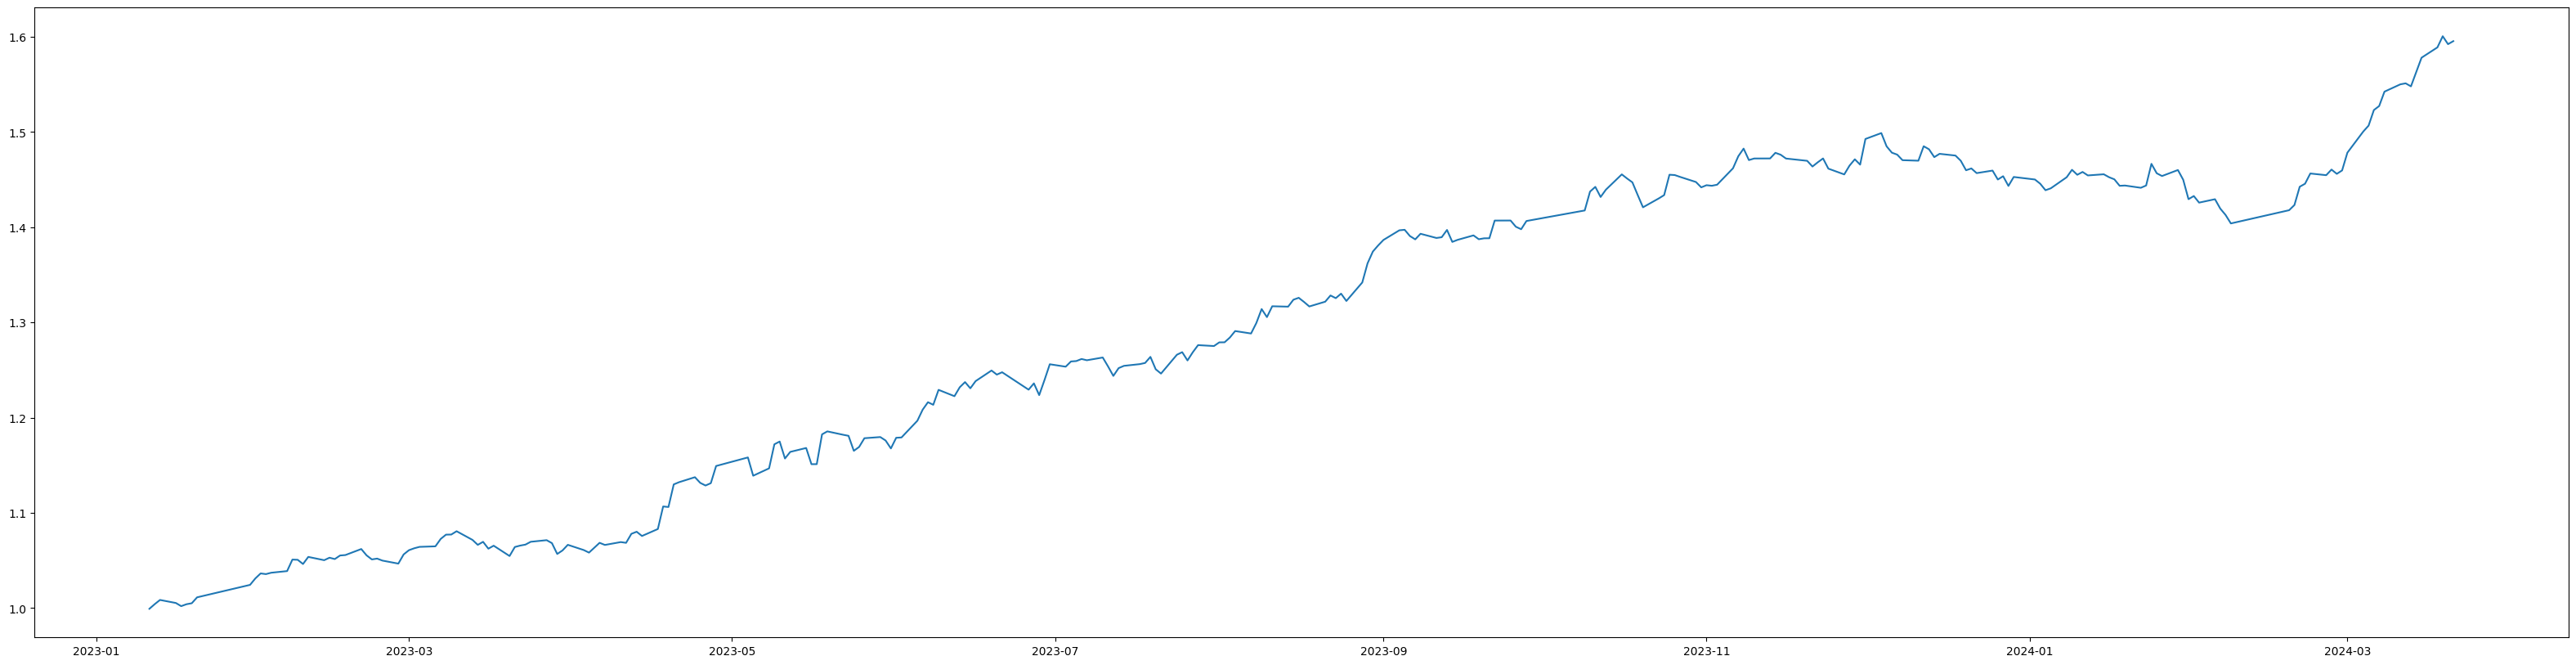

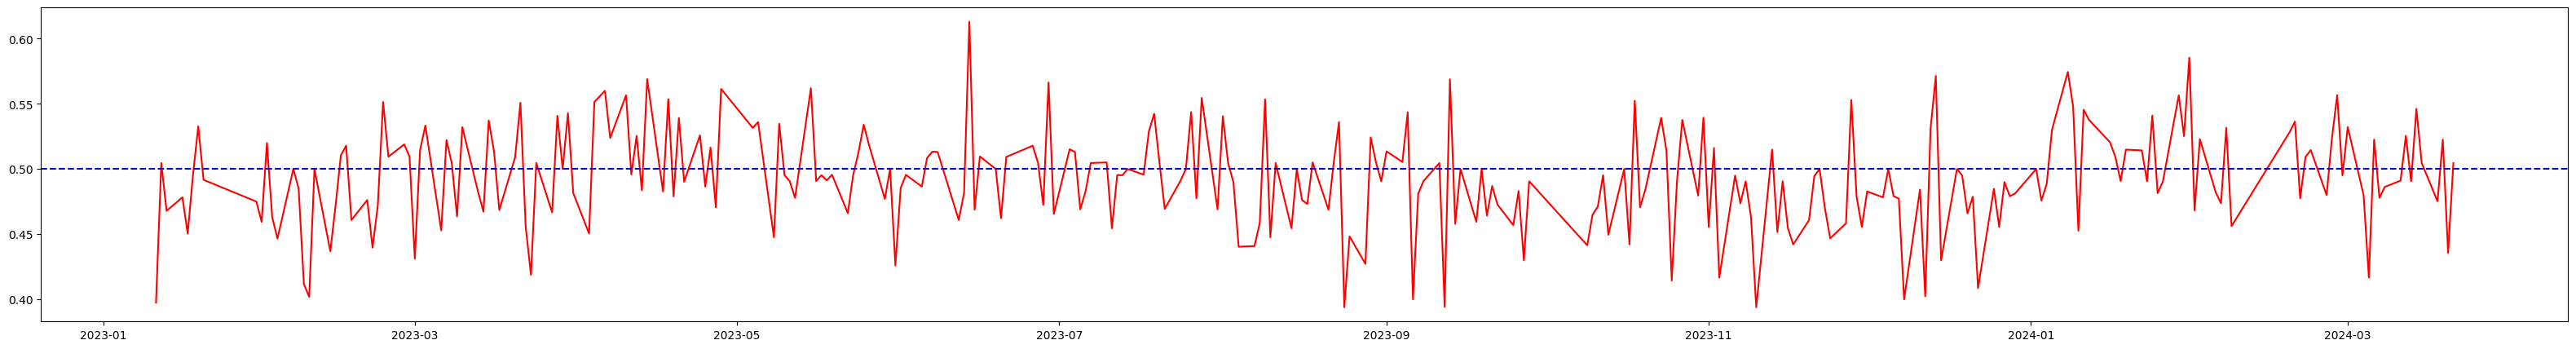

In [28]:
#绝对值排名,sota2,添加15s打分,全部股票,0708_国君_即时0，扣除印花税，尾盘vwap交易
from tqdm.notebook import tqdm
info_s = second_strategy(
    initial_money=100000000,
    min_ratio=0,
    ls_rank_ratio1=2.5,
    ls_rank_ratio2=3.5,
    score_ratio_1m=0.2, 
    score_ratio_15s=0.2,
    score_ratio_5m=0.6,
    ls_open=0,
    ls_back=2,
    ts_open_ratio=0.002,
    ts_back_ratio=0.002,
    amp_ratio=0.5,
    vol_limit=0.8,
    save_result=True)

  0%|          | 0/314 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c105585e0>
Traceback (most recent call last):
  File "/home/datamake8/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/datamake8/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/home/datamake8/.python3.8.0/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4c105585e0>
Traceback (most recent call last):
  File "/home/datamake8/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/datamake8/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", lin

0 2023-01-11 9.334034323096276e-05 0.6634929528192695 9.334034323096276e-05
1 2023-01-12 0.00047198024379223585 0.49499936160390956 0.0005653205870231986
2 2023-01-13 0.0035603769156768916 0.5716914820597372 0.00412569750270009
3 2023-01-16 0.0011888114808389545 0.7032185647686985 0.005314508983539044
4 2023-01-17 -0.0036555642348137496 0.6468269432386242 0.0016589447487252947
5 2023-01-18 0.0065161707854491475 0.5696903523946438 0.008175115534174443
6 2023-01-19 -0.0027523344701457023 0.6289659827745602 0.00542278106402874
7 2023-01-20 0.00757691022532165 0.6939905476439568 0.012999691289350392
8 2023-01-30 -0.0013983650660637022 0.6371092306461007 0.01160132622328669
9 2023-01-31 0.007780051506030262 0.6675475726612402 0.019381377729316952
10 2023-02-01 0.00042968099054992197 0.6456704292254786 0.019811058719866874
11 2023-02-02 0.003983724459707439 0.6153638604713761 0.023794783179574314
12 2023-02-03 0.0030739311337375642 0.6211212472218883 0.02686871431331188
13 2023-02-06 0.00103

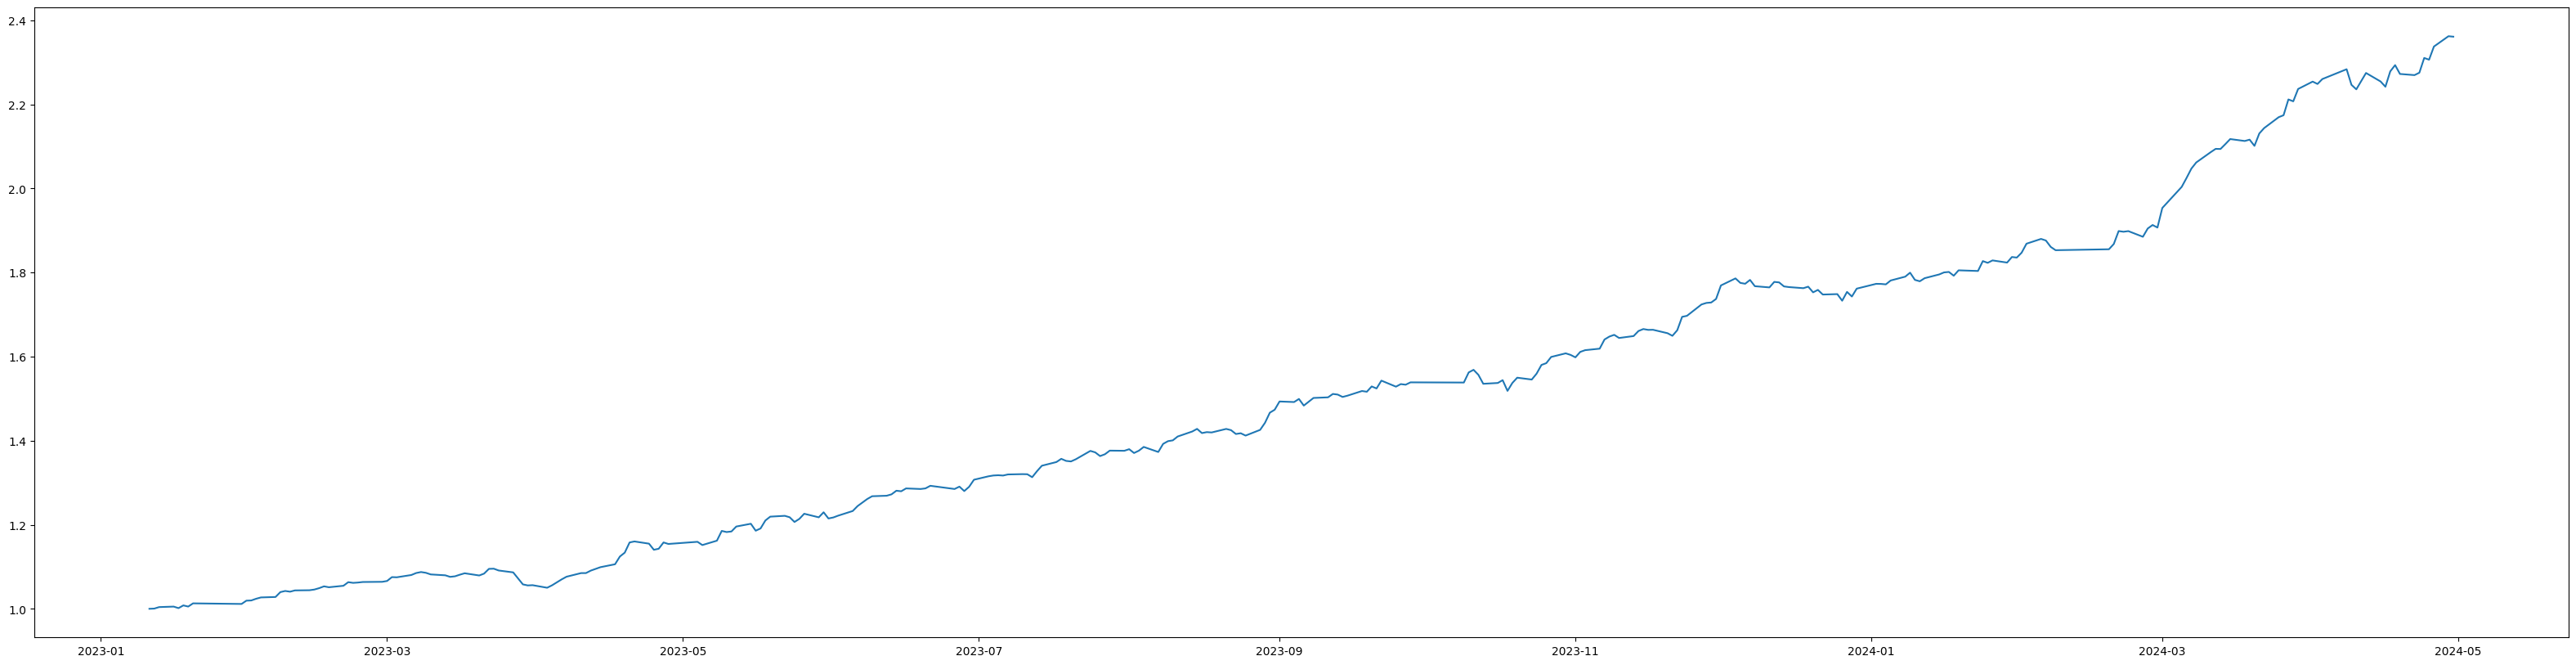

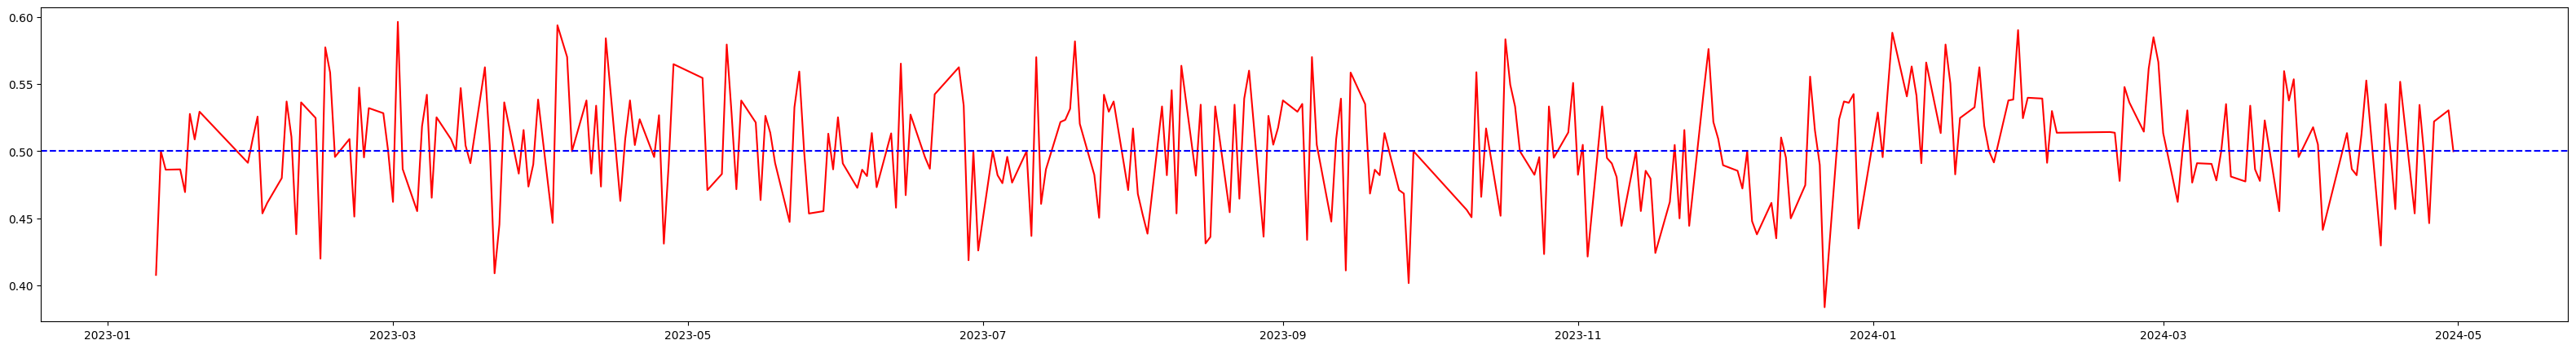

In [15]:
#绝对值排名,sota2,添加15s打分,全部股票,0705_海通_即时8，扣除印花税，尾盘vwap交易
from tqdm.notebook import tqdm
info_s = second_strategy(
    initial_money=100000000,
    min_ratio=0,
    ls_rank_ratio1=2.5,
    ls_rank_ratio2=3.5,
    score_ratio_1m=0.2, 
    score_ratio_15s=0.2,
    score_ratio_5m=0.6,
    ls_open=0,
    ls_back=2,
    ts_open_ratio=0.002,
    ts_back_ratio=0.002,
    amp_ratio=0.5,
    vol_limit=0.8,
    save_result=True)